# setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
%%capture
!pip install git+https://github.com/EleutherAI/sae.git

In [ ]:
# you should load this before cloning repo files
# from .config import SaeConfig
# from .utils import decoder_impl

from sae.config import SaeConfig
from sae.utils import decoder_impl
from sae import Sae

Triton not installed, using eager implementation of SAE decoder.


In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import json
from fnmatch import fnmatch
from pathlib import Path
from typing import NamedTuple, Optional, Callable, Union, List, Tuple
# from jaxtyping import Float, Int

import einops
import torch
from torch import Tensor, nn
from huggingface_hub import snapshot_download
from natsort import natsorted
from safetensors.torch import load_model, save_model

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from collections import Counter

## corr fns

In [ ]:
def batched_correlation(reshaped_activations_A, reshaped_activations_B, batch_size=100):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    num_batches = (normalized_B.shape[1] + batch_size - 1) // batch_size
    max_values = []
    max_indices = []

    for batch in range(num_batches):
        start = batch * batch_size
        end = min(start + batch_size, normalized_B.shape[1])
        batch_corr_matrix = torch.matmul(normalized_A.t(), normalized_B[:, start:end]) / normalized_A.shape[0]
        max_val, max_idx = batch_corr_matrix.max(dim=0)
        max_values.append(max_val)
        # max_indices.append(max_idx + start)  # Adjust indices for the batch offset
        max_indices.append(max_idx)  # Adjust indices for the batch offset

        del batch_corr_matrix
        torch.cuda.empty_cache()

    return torch.cat(max_indices), torch.cat(max_values)

## sim fns

In [ ]:
import functools
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import numpy.typing as npt
import torch


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(
    R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad"
) -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def sim_random_baseline(
    rep1: torch.Tensor, rep2: torch.Tensor, sim_func: Callable, n_permutations: int = 10
) -> Dict[str, Any]:
    torch.manual_seed(1234)
    scores = []
    for _ in range(n_permutations):
        perm = torch.randperm(rep1.size(0))

        score = sim_func(rep1[perm, :], rep2)
        score = score if isinstance(score, float) else score["score"]

        scores.append(score)

    return {"baseline_scores": np.array(scores)}


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray], Dict[str, Any]],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray) -> Dict[str, Any]:
        for preprocess_func in self.preprocess_funcs:
            R = preprocess_func(R)
            Rp = preprocess_func(Rp)
        return self.similarity_func(R, Rp)

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return (
                func.__name__
                if not isinstance(func, functools.partial)
                else func.func.__name__
            )

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )

In [ ]:
from typing import List, Set, Union

import numpy as np
import numpy.typing as npt
import sklearn.neighbors
import torch

# from llmcomp.measures.utils import to_numpy_if_needed


def _jac_sim_i(idx_R: Set[int], idx_Rp: Set[int]) -> float:
    return len(idx_R.intersection(idx_Rp)) / len(idx_R.union(idx_Rp))


def jaccard_similarity(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    k: int = 10,
    inner: str = "cosine",
    n_jobs: int = 8,
) -> float:
    R, Rp = to_numpy_if_needed(R, Rp)

    indices_R = nn_array_to_setlist(top_k_neighbors(R, k, inner, n_jobs))
    indices_Rp = nn_array_to_setlist(top_k_neighbors(Rp, k, inner, n_jobs))

    return float(
        np.mean(
            [_jac_sim_i(idx_R, idx_Rp) for idx_R, idx_Rp in zip(indices_R, indices_Rp)]
        )
    )


def top_k_neighbors(
    R: npt.NDArray,
    k: int,
    inner: str,
    n_jobs: int,
) -> npt.NDArray:
    # k+1 nearest neighbors, because we pass in all the data, which means that a point
    # will be the nearest neighbor to itself. We remove this point from the results and
    # report only the k nearest neighbors distinct from the point itself.
    nns = sklearn.neighbors.NearestNeighbors(
        n_neighbors=k + 1, metric=inner, n_jobs=n_jobs
    )
    nns.fit(R)
    _, nns = nns.kneighbors(R)
    return nns[:, 1:]


def nn_array_to_setlist(nn: npt.NDArray) -> List[Set[int]]:
    return [set(idx) for idx in nn]

In [ ]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [ ]:
from typing import Optional
from typing import Union

import numpy as np
import numpy.typing as npt
import scipy.spatial.distance
import scipy.stats
import sklearn.metrics
import torch
# from repsim.measures.utils import flatten
# from repsim.measures.utils import RSMSimilarityMeasure
# from repsim.measures.utils import SHAPE_TYPE
# from repsim.measures.utils import to_numpy_if_needed


def representational_similarity_analysis(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
    inner="correlation",
    outer="spearman",
    n_jobs: Optional[int] = None,
) -> float:
    """Representational similarity analysis

    Args:
        R (Union[torch.Tensor, npt.NDArray]): N x D representation
        Rp (Union[torch.Tensor, npt.NDArray]): N x D' representation
        inner (str, optional): inner similarity function for RSM. Must be one of
            scipy.spatial.distance.pdist identifiers . Defaults to "correlation".
        outer (str, optional): outer similarity function that compares RSMs. Defaults to
             "spearman". Must be one of "spearman", "euclidean"

    Returns:
        float: _description_
    """
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)

    if inner == "correlation":
        # n_jobs only works if metric is in PAIRWISE_DISTANCES as defined in sklearn, i.e., not for correlation.
        # But correlation = 1 - cosine dist of row-centered data, so we use the faster cosine metric and center the data.
        R = R - R.mean(axis=1, keepdims=True)
        S = scipy.spatial.distance.squareform(  # take the lower triangle of RSM
            1 - sklearn.metrics.pairwise_distances(R, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
        Rp = Rp - Rp.mean(axis=1, keepdims=True)
        Sp = scipy.spatial.distance.squareform(
            1 - sklearn.metrics.pairwise_distances(Rp, metric="cosine", n_jobs=n_jobs),  # type:ignore
            checks=False,
        )
    elif inner == "euclidean":
        # take the lower triangle of RSM
        S = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(R, metric=inner, n_jobs=n_jobs), checks=False
        )
        Sp = scipy.spatial.distance.squareform(
            sklearn.metrics.pairwise_distances(Rp, metric=inner, n_jobs=n_jobs), checks=False
        )
    else:
        raise NotImplementedError(f"{inner=}")

    if outer == "spearman":
        return scipy.stats.spearmanr(S, Sp).statistic  # type:ignore
    elif outer == "euclidean":
        return float(np.linalg.norm(S - Sp, ord=2))
    else:
        raise ValueError(f"Unknown outer similarity function: {outer}")


class RSA(RSMSimilarityMeasure):
    def __init__(self):
        # choice of inner/outer in __call__ if fixed to default values, so these values are always the same
        super().__init__(
            sim_func=representational_similarity_analysis,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

In [ ]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## get rand

In [ ]:
def score_rand(num_feats, sim_fn, shapereq_bool=False):
    all_rand_scores = []
    for i in range(1):
        rand_modA_feats = np.random.randint(low=0, high=weight_matrix_np.shape[0], size=num_feats).tolist()
        rand_modB_feats = np.random.randint(low=0, high=weight_matrix_2.shape[0], size=num_feats).tolist()

        if shapereq_bool:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
        else:
            score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
        all_rand_scores.append(score)
    # print(sum(all_rand_scores) / len(all_rand_scores))
    # plt.hist(all_rand_scores)
    # plt.show()
    return sum(all_rand_scores) / len(all_rand_scores)

In [ ]:
# import random
# row_idxs = list(range(weight_matrix_2.shape[0]))
# random.shuffle(row_idxs)
# jaccard_similarity(weight_matrix_np, weight_matrix_2[row_idxs])

## plot fns

In [ ]:
def plot_svcca_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['svcca_paired'] for i in range(0, 12)]
    unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr'] for i in range(0, 12)]
    # unpaired_values = [layer_to_dictscores[i]['svcca_unpaired'] for i in range(0, 12)]

    # Plotting configuration
    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    # Increase figure size
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
    # rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

    # Adding labels, title and custom x-axis tick labels
    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    # Rotate labels and adjust padding
    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            # if i % 2 == 0:  # Label every other bar above
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12) # , rotation=90
            # else:  # Label every other bar below
            #     ax.text(rect.get_x() + rect.get_width()/2., 0,
            #             f'{height:.3f}',
            #             ha='center', va='top', rotation=90)

    label_bars(rects1)
    # label_bars(rects2)

    # Adjust layout to prevent cutting off labels
    plt.tight_layout()

    plt.show()

In [ ]:
def plot_meanCorr_filt_byLayer(layer_to_dictscores):
    for key, sub_dict in layer_to_dictscores.items():
        for sub_key, value in sub_dict.items():
            sub_dict[sub_key] = round(value, 4)

    layers = [f'L{i}' for i in range(0, 12)]
    paired_values = [layer_to_dictscores[i]['mean_actv_corr_filt'] for i in range(0, 12)]

    x = np.arange(len(layers))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')

    ax.set_ylabel('SVCCA')
    ax.set_title(f'SAEs comparison by Pythia 70m MLP{layer_id} vs 160m MLP Layers')
    ax.set_xticks(x)
    ax.set_xticklabels(layers)
    ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
    ax.legend()

    def label_bars(rects):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=12)

    label_bars(rects1)
    plt.tight_layout()

    plt.show()

In [ ]:
# def plot_js_byLayer(layer_to_dictscores):
#     for key, sub_dict in layer_to_dictscores.items():
#         for sub_key, value in sub_dict.items():
#             sub_dict[sub_key] = round(value, 4)

#     layers = [f'L{i}' for i in range(0, 12)]
#     paired_values = [layer_to_dictscores[i]['1-1 jaccard_paired'] for i in range(0, 12)]
#     unpaired_values = [layer_to_dictscores[i]['1-1 jaccard_unpaired'] for i in range(0, 12)]

#     # Plotting configuration
#     x = np.arange(len(layers))  # label locations
#     width = 0.35  # width of the bars

#     # Increase figure size
#     fig, ax = plt.subplots(figsize=(12, 7))  # Slightly increased figure size
#     rects1 = ax.bar(x - width/2, paired_values, width, label='Paired')
#     rects2 = ax.bar(x + width/2, unpaired_values, width, label='Unpaired')

#     # Adding labels, title and custom x-axis tick labels
#     ax.set_ylabel('Jaccard NN')
#     ax.set_title('SAEs comparison by Pythia 70m MLP0 vs 160m MLP Layers')
#     ax.set_xticks(x)
#     ax.set_xticklabels(layers)
#     ax.set_ylim(0, 1)  # Ensuring y-axis is scaled from 0 to 1
#     ax.legend()

#     # Label bars with increased font size and different positioning for paired and unpaired
#     def label_bars(rects, is_paired):
#         for rect in rects:
#             height = rect.get_height()
#             label_height = height + 0.05 if is_paired else height + 0.01
#             ax.text(rect.get_x() + rect.get_width()/2., label_height,
#                     f'{height:.3f}',
#                     ha='center', va='bottom', fontsize=9)  # Increased font size to 12

#     label_bars(rects1, True)   # Paired bars
#     label_bars(rects2, False)  # Unpaired bars

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     # Increase y-axis limit to accommodate higher labels
#     ax.set_ylim(0, 1.1)  # Increased from 1 to 1.1

#     plt.show()

## interpret fns

In [ ]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [ ]:
from rich import print as rprint
def display_top_sequences(top_acts_indices, top_acts_values, batch_tokens):
    s = ""
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        # s += f'{batch_idx}\n'
        s += f'batchID: {batch_idx}, '
        # Get the sequence as a string (with some padding on either side of our sequence)
        seq_start = max(seq_idx - 5, 0)
        seq_end = min(seq_idx + 5, batch_tokens.shape[1])
        seq = ""
        # Loop over the sequence, adding each token to the string (highlighting the token with the large activations)
        for i in range(seq_start, seq_end):
            # new_str_token = model.to_single_str_token(batch_tokens[batch_idx, i].item()).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            new_str_token = tokenizer.decode([batch_tokens[batch_idx, i].item()]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
            if i == seq_idx:
                new_str_token = f"[bold u dark_orange]{new_str_token}[/]"
            seq += new_str_token
        # Print the sequence, and the activation value
        s += f'Act = {value:.2f}, Seq = "{seq}"\n'

    rprint(s)

# load data

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from datasets import load_dataset
# dataset = load_dataset("roneneldan/TinyStories", split="train", streaming=True)
dataset = load_dataset("Skylion007/openwebtext", split="train", streaming=True)

The repository for Skylion007/openwebtext contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/Skylion007/openwebtext.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
batch_size = 100
maxseqlen = 300

def get_next_batch(dataset_iter, batch_size=100):
    batch = []
    for _ in range(batch_size):
        try:
            sample = next(dataset_iter)
            batch.append(sample['text'])
        except StopIteration:
            break
    return batch

dataset_iter = iter(dataset)
batch = get_next_batch(dataset_iter, batch_size)

# Tokenize the batch
inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=maxseqlen)

# load models

In [ ]:
model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
model_2 = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-160m")

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

# MLP2 vs

## load SAE model A

In [ ]:
layer_id = 2
hookpoint = "layers." + str(layer_id)
name = "EleutherAI/sae-pythia-70m-32k"
decoder=True

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 512}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_np = sae.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model(**inputs, output_hidden_states=True)
    reshaped_activations_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_A.shape[0] * reshaped_activations_A.shape[1]
reshaped_activations_A = reshaped_activations_A.reshape(first_dim_reshaped, reshaped_activations_A.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

### num weight cols that are 0

In [ ]:
def count_zero_columns(tensor):
    # Check if all elements in each column are zero
    zero_columns = np.all(tensor == 0, axis=0)
    # Count True values in the zero_columns array
    zero_cols_indices = np.where(zero_columns)[0]
    return np.sum(zero_columns), zero_cols_indices

# Count zero columns
zero_cols_count, zero_cols_indices = count_zero_columns(reshaped_activations_A.cpu().numpy())
print("Number of zero columns:", zero_cols_count) #, zero_cols_indices

Number of zero columns: 5516


## layer pair, analyze corr

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

# for i in range(1, 3): # 0, 12
i=2
dictscores = {}

hookpoint = "layers." + str(i)

repo_path = Path(
            snapshot_download(
                name,
                allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                # allow_patterns = None
            )
        )
if hookpoint is not None:
    repo_path = repo_path / hookpoint
path = Path(repo_path)
cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
d_in = cfg_dict.pop("d_in")
cfg = SaeConfig(**cfg_dict)

sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

load_model(
    model=sae_2,
    filename=str(path / "sae.safetensors"),
    device=str(device),
    strict=decoder,
)

weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

with torch.inference_mode():
    outputs = model_2(**inputs, output_hidden_states=True)
    reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
"""
`batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
"""
highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

% unique:  0.23333740234375


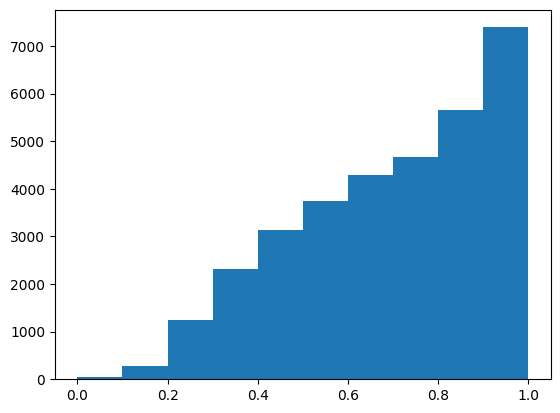

In [ ]:
plt.hist(highest_correlations_values_AB)
plt.show()

In [ ]:
sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
for rankID in range(20):
    feat_ID = sorted_feat_counts[rankID][0]
    print("FeatID: ", feat_ID, "| Count: ", sorted_feat_counts[rankID][1],
          "| Corr: ", highest_correlations_values_AB[feat_ID])

FeatID:  2604 | Count:  1867 | Corr:  0.9148081
FeatID:  11415 | Count:  1272 | Corr:  0.39981055
FeatID:  16337 | Count:  885 | Corr:  0.798584
FeatID:  32697 | Count:  617 | Corr:  0.18044904
FeatID:  21787 | Count:  331 | Corr:  0.7753681
FeatID:  32352 | Count:  325 | Corr:  0.84321123
FeatID:  12813 | Count:  260 | Corr:  0.9459207
FeatID:  18972 | Count:  254 | Corr:  0.47722584
FeatID:  12313 | Count:  250 | Corr:  0.94422275
FeatID:  18186 | Count:  246 | Corr:  0.9498456
FeatID:  32565 | Count:  221 | Corr:  0.3425599
FeatID:  24468 | Count:  216 | Corr:  0.25493762
FeatID:  1182 | Count:  167 | Corr:  0.7401721
FeatID:  3128 | Count:  165 | Corr:  0.37767866
FeatID:  15282 | Count:  141 | Corr:  0.73332477
FeatID:  17626 | Count:  110 | Corr:  0.61508304
FeatID:  10852 | Count:  107 | Corr:  0.74052733
FeatID:  22809 | Count:  95 | Corr:  0.7157822
FeatID:  10593 | Count:  89 | Corr:  0.7055516
FeatID:  21744 | Count:  81 | Corr:  0.82881176


In [ ]:
# num_featB_to_rmv
sum([item[1] for item in sorted_feat_counts[:17]])

7434

In [ ]:
max_element = len(highest_correlations_indices_AB)
counts = Counter(highest_correlations_indices_AB)

# Initialize bins
bin_0 = 0
bin_1 = 0
bin_2_to_10 = 0
bin_11_to_100 = 0
bin_101_to_1000 = 0
bin_over_1000 = 0

# Calculate bins
for i in range(max_element + 1):
    count = counts.get(i, 0)
    if count == 0:
        bin_0 += 1
    elif count == 1:
        bin_1 += 1
    elif 2 <= count <= 10:
        bin_2_to_10 += 1
    elif 11 <= count <= 100:
        bin_11_to_100 += 1
    elif 101 <= count <= 1000:
        bin_101_to_1000 += 1
    elif count > 1000:
        bin_over_1000 += 1

# Display bin counts
print(f"Count of elements appearing 0 times: {bin_0}")
print(f"Count of elements appearing exactly 1 time: {bin_1}")
print(f"Count of elements appearing between 2 and 10 times: {bin_2_to_10}")
print(f"Count of elements appearing between 11 and 100 times: {bin_11_to_100}")
print(f"Count of elements appearing between 101 and 1000 times: {bin_101_to_1000}")
print(f"Count of elements appearing over 1000 times: {bin_over_1000}")

Count of elements appearing 0 times: 25123
Count of elements appearing exactly 1 time: 2663
Count of elements appearing between 2 and 10 times: 4698
Count of elements appearing between 11 and 100 times: 268
Count of elements appearing between 101 and 1000 times: 15
Count of elements appearing over 1000 times: 2


## interpret

In [ ]:
# load weight matrix too

# with torch.inference_mode():
    # outputs = model(**inputs, output_hidden_states=True)
    # feature_acts_model_A = sae.pre_acts(outputs.hidden_states[layer_id].to("cuda"))
    # feature_acts_model_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

In [ ]:
sorted_feat_counts[:5]

[(2604, 1867), (11415, 1272), (16337, 885), (32697, 617), (21787, 331)]

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

feature_idx_A = sorted_feat_counts[0][0]
print('Model A Feature: ', feature_idx_A)
ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

Model A Feature:  2604


batchID: 33, Act = 2.93, Seq = " the course of four days. Here’s pre"
batchID: 21, Act = 2.85, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 2.73, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 27, Act = 2.68, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 37, Act = 2.66, Seq = "Executive summary\n\nThis paper reviews"

In [ ]:
feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == 2604]
len(feat_B_lst)

1867

In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_B in feat_B_lst[:5]:
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    # print('Model A Feature: ', feature_idx_A)
    # ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=batch_tokens)
    # display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=batch_tokens)

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Correlation: 0.7680619955062866
Model B Feature:  1


batchID: 92, Act = 2.28, Seq = " Donald John TrumpREAD: Cohen testimony alleges Trump knew"
batchID: 36, Act = 1.00, Seq = "Whenever something momentous happens"
batchID: 50, Act = 0.69, Seq = " after the shooting at Virginia Tech University that killed 32"
batchID: 54, Act = 0.64, Seq = "SHARE Gov. Scott Walker Friday named"
batchID: 26, Act = 0.62, Seq = "” that costs $450. In this post I"

--------------------------------------------------
Correlation: 0.9418676495552063
Model B Feature:  24


batchID: 55, Act = 2.01, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 9, Act = 1.99, Seq = " music and IKEA. But it looks like"
batchID: 43, Act = 1.89, Seq = " by a guest lecturer.\n\nWaving"
batchID: 76, Act = 1.88, Seq = "ar al-Assad.\n\nHik"
batchID: 46, Act = 1.87, Seq = " the furry encyclopedia.\n\nFoxy"

--------------------------------------------------
Correlation: 0.8840045928955078
Model B Feature:  40


batchID: 98, Act = 2.00, Seq = " says these types of outbursts were commonplace from"
batchID: 1, Act = 1.30, Seq = " a campaign rally in St. Louis on Saturday."
batchID: 72, Act = 1.20, Seq = " his phone, when Coun. Matthew Green was stopped"
batchID: 60, Act = 1.09, Seq = "FILE - In this Dec. 17, 2015,"
batchID: 97, Act = 1.07, Seq = " approximately 07:13 a.m., the Co"

--------------------------------------------------
Correlation: 0.928622305393219
Model B Feature:  47


batchID: 97, Act = 1.08, Seq = " approximately 07:13 a.m., the Co"
batchID: 13, Act = 1.01, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 43, Act = 1.00, Seq = " by a guest lecturer.\n\nWaving"
batchID: 76, Act = 0.99, Seq = "ar al-Assad.\n\nHik"
batchID: 27, Act = 0.98, Seq = " the New York Stock Exchange.\n\nThe Dow"

--------------------------------------------------
Correlation: 0.942076563835144
Model B Feature:  57


batchID: 0, Act = 1.25, Seq = " it was concerned about security.\n\nThe decision"
batchID: 21, Act = 1.25, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 28, Act = 1.24, Seq = " economic reality that surrounds us. This leads to a"
batchID: 34, Act = 1.24, Seq = " virtually nothing but a lawsuit.\n\nThe Hig"
batchID: 36, Act = 1.23, Seq = " to appear and observe proceedings. In the Marvel Universe"

--------------------------------------------------


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[:5]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[0]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 1867
Correlation: 0.7680619955062866
Model A Feature:  2604


batchID: 33, Act = 2.93, Seq = " the course of four days. Here’s pre"
batchID: 21, Act = 2.85, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 2.73, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 27, Act = 2.68, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 37, Act = 2.66, Seq = "Executive summary\n\nThis paper reviews"

Model B Feature:  1


batchID: 92, Act = 2.28, Seq = " Donald John TrumpREAD: Cohen testimony alleges Trump knew"
batchID: 36, Act = 1.00, Seq = "Whenever something momentous happens"
batchID: 50, Act = 0.69, Seq = " after the shooting at Virginia Tech University that killed 32"
batchID: 54, Act = 0.64, Seq = "SHARE Gov. Scott Walker Friday named"
batchID: 26, Act = 0.62, Seq = "” that costs $450. In this post I"

--------------------------------------------------
Count: 1272
Correlation: 0.768714964389801
Model A Feature:  11415


batchID: 13, Act = 1.53, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 33, Act = 1.42, Seq = " the course of four days. Here’s pre"
batchID: 56, Act = 1.41, Seq = "’t know for sure. But the trackers"
batchID: 97, Act = 1.36, Seq = " approximately 07:13 a.m., the Co"
batchID: 26, Act = 1.35, Seq = "” that costs $450. In this post I"

Model B Feature:  17


batchID: 18, Act = 0.49, Seq = " game. Cheating steals the next card in"
batchID: 55, Act = 0.43, Seq = " Cleveland and Ferguson, Mo. (Photo by Tas"
batchID: 26, Act = 0.40, Seq = "” that costs $450. In this post I"
batchID: 67, Act = 0.40, Seq = "No. 1 - Retired"
batchID: 51, Act = 0.39, Seq = " close contact with Remontowa and LMG Design"

--------------------------------------------------
Count: 885
Correlation: 0.7165458798408508
Model A Feature:  16337


batchID: 21, Act = 1.48, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 49, Act = 1.47, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 39, Act = 1.47, Seq = " August, police have said.\n\nThe 28"
batchID: 27, Act = 1.46, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 44, Act = 1.46, Seq = " tale of New Jersey politics. So it is only"

Model B Feature:  20


batchID: 99, Act = 2.62, Seq = " imperfect but they are extremely helpful to predict the weather"
batchID: 47, Act = 2.45, Seq = " your fancy. A super handy feature in a city"
batchID: 98, Act = 1.28, Seq = " draw tens of millions of loyal listeners and viewers on"
batchID: 99, Act = 1.17, Seq = ", but some models are useful”. In simulating"
batchID: 33, Act = 1.02, Seq = "-hand side might be useful to track the forward"

--------------------------------------------------
Count: 617
Correlation: 0.7066294550895691
Model A Feature:  32697


batchID: 37, Act = 6.41, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 5.48, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 77, Act = 5.27, Seq = " is over 7 years old\n\nMajor rights holders"
batchID: 49, Act = 5.05, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 56, Act = 4.95, Seq = "’t know for sure. But the trackers"

Model B Feature:  202


batchID: 26, Act = 1.45, Seq = "” that costs $450. In this post I"
batchID: 3, Act = 1.34, Seq = " entities that transcends language. It’s one"
batchID: 98, Act = 1.32, Seq = " in ultra-trouble. The famous TV host"
batchID: 49, Act = 1.31, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 46, Act = 1.29, Seq = " the furry encyclopedia.\n\nFoxy"

--------------------------------------------------
Count: 331
Correlation: 0.9603273272514343
Model A Feature:  21787


batchID: 37, Act = 3.90, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 2.78, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 56, Act = 2.66, Seq = "’t know for sure. But the trackers"
batchID: 72, Act = 2.56, Seq = " his phone, when Coun. Matthew Green was stopped"
batchID: 77, Act = 2.54, Seq = " is over 7 years old\n\nMajor rights holders"

Model B Feature:  86


batchID: 69, Act = 1.68, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 78, Act = 1.63, Seq = " Dr David Kelly inquest\n\nFound in woods"
batchID: 87, Act = 1.63, Seq = "razer Brown writes,\n\nAt London Super"
batchID: 91, Act = 1.55, Seq = " century, new research shows\n\nHouseholds are"
batchID: 71, Act = 1.53, Seq = " Suspect Has Died\n\nEnlarge this"

--------------------------------------------------


In [ ]:
samp_m = 5 # get top samp_m tokens for all top feat_k feature neurons

for feature_idx_A, count in sorted_feat_counts[6:15]:
    feat_B_lst = [ind_B for ind_B, ind_A in enumerate(highest_correlations_indices_AB) if ind_A == feature_idx_A]
    feature_idx_B = feat_B_lst[0]
    print(f'Count: {count}')
    print(f'Correlation: {highest_correlations_values_AB[feature_idx_B]}')
    print('Model A Feature: ', feature_idx_A)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_A, feature_idx_A, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('Model B Feature: ', feature_idx_B)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(feature_acts_model_B, feature_idx_B, samp_m, batch_tokens=inputs["input_ids"])
    display_top_sequences(ds_top_acts_indices, ds_top_acts_values, batch_tokens=inputs["input_ids"])

    print('-'*50)

Count: 260
Correlation: 0.7802252769470215
Model A Feature:  12813


batchID: 37, Act = 1.77, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 1.46, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 93, Act = 1.32, Seq = " Threats To Free Speech\n\nAbove Photo:"
batchID: 59, Act = 1.31, Seq = " Riot Jynx\n\nCheck out the"
batchID: 67, Act = 1.30, Seq = "No. 1 - Retired"

Model B Feature:  149


batchID: 97, Act = 0.58, Seq = " approximately 07:13 a.m., the Co"
batchID: 72, Act = 0.57, Seq = " his phone, when Coun. Matthew Green was stopped"
batchID: 69, Act = 0.52, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 78, Act = 0.51, Seq = " Dr David Kelly inquest\n\nFound in woods"
batchID: 26, Act = 0.49, Seq = "” that costs $450. In this post I"

--------------------------------------------------
Count: 254
Correlation: 0.6361518502235413
Model A Feature:  18972


batchID: 97, Act = 0.70, Seq = " approximately 07:13 a.m., the Co"
batchID: 21, Act = 0.66, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 33, Act = 0.64, Seq = " the course of four days. Here’s pre"
batchID: 27, Act = 0.62, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 35, Act = 0.61, Seq = ", monitors said on Tuesday.\n\nThe UK"

Model B Feature:  108


batchID: 10, Act = 2.83, Seq = "ic 1984 film "Purple Rain."\n\n"
batchID: 63, Act = 0.85, Seq = " his final weeks at Severn Hospice,"
batchID: 29, Act = 0.79, Seq = " mother of a fallen U.S. soldier of"
batchID: 60, Act = 0.78, Seq = " time.\n\nProsecutors in closing arguments"
batchID: 1, Act = 0.76, Seq = " a campaign rally in St. Louis on Saturday."

--------------------------------------------------
Count: 250
Correlation: 0.9260265827178955
Model A Feature:  12313


batchID: 37, Act = 1.37, Seq = "Executive summary\n\nThis paper reviews"
batchID: 13, Act = 1.03, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 3, Act = 1.02, Seq = " entities that transcends language. It’s one"
batchID: 49, Act = 1.01, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 27, Act = 1.00, Seq = " the New York Stock Exchange.\n\nThe Dow"

Model B Feature:  189


batchID: 69, Act = 1.21, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 42, Act = 1.17, Seq = " heart, a study shows\n\nPeople who have"
batchID: 6, Act = 1.16, Seq = " but others decided against it\n\nSEATTLE"
batchID: 78, Act = 1.11, Seq = " Dr David Kelly inquest\n\nFound in woods"
batchID: 91, Act = 1.08, Seq = " century, new research shows\n\nHouseholds are"

--------------------------------------------------
Count: 246
Correlation: 0.75460284948349
Model A Feature:  18186


batchID: 37, Act = 1.45, Seq = "Executive summary\n\nThis paper reviews"
batchID: 91, Act = 1.25, Seq = " century, new research shows\n\nHouseholds are"
batchID: 69, Act = 1.13, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 20, Act = 1.05, Seq = " than £150,000\n\nThe Liberal Democrats"
batchID: 48, Act = 1.02, Seq = " Help Out New Pal China\n\nIsrael is a"

Model B Feature:  98


batchID: 69, Act = 0.68, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 1, Act = 0.63, Seq = " at the numbers. Because delegates are awarded proportionately"
batchID: 87, Act = 0.60, Seq = "razer Brown writes,\n\nAt London Super"
batchID: 91, Act = 0.57, Seq = " century, new research shows\n\nHouseholds are"
batchID: 42, Act = 0.56, Seq = " heart, a study shows\n\nPeople who have"

--------------------------------------------------
Count: 221
Correlation: 0.7598474025726318
Model A Feature:  32565


batchID: 13, Act = 2.03, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 33, Act = 2.02, Seq = " the course of four days. Here’s pre"
batchID: 70, Act = 1.93, Seq = " position to fight for playoffs. With a game in"
batchID: 49, Act = 1.84, Seq = " arm prepared for minor surgery. (Print by Abraham"
batchID: 21, Act = 1.75, Seq = " Friday evening and Monday morning.\n\nThe latest"

Model B Feature:  150


batchID: 1, Act = 2.13, Seq = " the challenges going forward after primary voters took to the"
batchID: 54, Act = 1.39, Seq = ".\n\n"The primary and only job of"
batchID: 21, Act = 0.76, Seq = " Friday evening and Monday morning.\n\nThe latest"
batchID: 76, Act = 0.75, Seq = "ar al-Assad.\n\nHik"
batchID: 80, Act = 0.74, Seq = " China last Saturday (5.7.2014)"

--------------------------------------------------
Count: 216
Correlation: 0.4897196590900421
Model A Feature:  24468


batchID: 37, Act = 1.92, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 1.44, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 59, Act = 1.37, Seq = " Riot Jynx\n\nCheck out the"
batchID: 82, Act = 1.36, Seq = " Solid: Phantom Pain\n\nBack in 2013"
batchID: 56, Act = 1.34, Seq = "’t know for sure. But the trackers"

Model B Feature:  191


batchID: 92, Act = 0.74, Seq = "NC emails Trump urges North Korea to denuclearize"
batchID: 88, Act = 0.70, Seq = " Print Mail Flipboard\n\nLibertarian"
batchID: 93, Act = 0.63, Seq = " Threats To Free Speech\n\nAbove Photo:"
batchID: 38, Act = 0.61, Seq = " to repeal and replace ObamaCare. The bill had"
batchID: 57, Act = 0.60, Seq = " sides closer, however, culminating in mutual support"

--------------------------------------------------
Count: 167
Correlation: 0.8352461457252502
Model A Feature:  1182


batchID: 37, Act = 0.94, Seq = "Executive summary\n\nThis paper reviews"
batchID: 59, Act = 0.88, Seq = " Riot Jynx\n\nCheck out the"
batchID: 69, Act = 0.84, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 91, Act = 0.81, Seq = " century, new research shows\n\nHouseholds are"
batchID: 77, Act = 0.75, Seq = " is over 7 years old\n\nMajor rights holders"

Model B Feature:  1097


batchID: 42, Act = 0.81, Seq = " heart, a study shows\n\nPeople who have"
batchID: 91, Act = 0.80, Seq = " century, new research shows\n\nHouseholds are"
batchID: 59, Act = 0.75, Seq = " Riot Jynx\n\nCheck out the"
batchID: 6, Act = 0.74, Seq = " but others decided against it\n\nSEATTLE"
batchID: 71, Act = 0.73, Seq = " Suspect Has Died\n\nEnlarge this"

--------------------------------------------------
Count: 165
Correlation: 0.7126517295837402
Model A Feature:  3128


batchID: 37, Act = 13.45, Seq = "Executive summary\n\nThis paper reviews"
batchID: 69, Act = 11.91, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 95, Act = 11.30, Seq = "ST. LOUIS —"
batchID: 77, Act = 11.19, Seq = " is over 7 years old\n\nMajor rights holders"
batchID: 29, Act = 11.08, Seq = " mother of a fallen U.S. soldier of"

Model B Feature:  76


batchID: 3, Act = 1.56, Seq = " announced its world tour to promote the release of its"
batchID: 69, Act = 1.31, Seq = "’s lackeys to promote its political agenda in"
batchID: 5, Act = 1.29, Seq = " he did not intend to promote hate speech; instead"
batchID: 25, Act = 1.26, Seq = " to go out alone and controlling everything that they do"
batchID: 5, Act = 1.05, Seq = "; instead he wanted to stimulate debate about censorship,"

--------------------------------------------------
Count: 141
Correlation: 0.515930712223053
Model A Feature:  15282


batchID: 27, Act = 0.88, Seq = " the New York Stock Exchange.\n\nThe Dow"
batchID: 69, Act = 0.87, Seq = " an even more uncertain future\n\nEmotions ran"
batchID: 37, Act = 0.86, Seq = "Executive summary\n\nThis paper reviews"
batchID: 13, Act = 0.85, Seq = " sometimes things are more complicated.\n\nAdBlock"
batchID: 56, Act = 0.85, Seq = "’t know for sure. But the trackers"

Model B Feature:  143


batchID: 32, Act = 1.87, Seq = "\nAdams, a native of Wappinger"
batchID: 91, Act = 0.94, Seq = "holds are facing the most savage peacetime squeeze"
batchID: 64, Act = 0.50, Seq = "abbard, the first Hindu American elected to the"
batchID: 76, Act = 0.45, Seq = " member of Israel's Arab minority, attends a"
batchID: 26, Act = 0.40, Seq = "” that costs $450. In this post I"

--------------------------------------------------


## loop- filter counts over 10 and rmv corr of 0

In [ ]:
layer_to_dictscores = {}
name = "EleutherAI/sae-pythia-160m-32k"
decoder=True

for i in range(0, 12): # 0, 12
    dictscores = {}

    hookpoint = "layers." + str(i)

    repo_path = Path(
                snapshot_download(
                    name,
                    allow_patterns=f"{hookpoint}/*" if hookpoint is not None else None,
                    # allow_patterns = None
                )
            )
    if hookpoint is not None:
        repo_path = repo_path / hookpoint
    path = Path(repo_path)
    cfg_dict = {"expansion_factor": 32, "normalize_decoder": True, "num_latents": 32768, "k": 16, "d_in": 768}
    d_in = cfg_dict.pop("d_in")
    cfg = SaeConfig(**cfg_dict)

    sae_2 = Sae(d_in, cfg, device=device, decoder=decoder)

    load_model(
        model=sae_2,
        filename=str(path / "sae.safetensors"),
        device=str(device),
        strict=decoder,
    )

    weight_matrix_2 = sae_2.W_dec.cpu().detach().numpy()

    with torch.inference_mode():
        outputs = model_2(**inputs, output_hidden_states=True)
        reshaped_activations_B = sae_2.pre_acts(outputs.hidden_states[layer_id].to("cuda"))

    first_dim_reshaped = reshaped_activations_B.shape[0] * reshaped_activations_B.shape[1]
    reshaped_activations_B = reshaped_activations_B.reshape(first_dim_reshaped, reshaped_activations_B.shape[-1]).cpu()

    """
    `batched_correlation(reshaped_activations_B, reshaped_activations_A)` : highest_correlations_indices_AB contains modA's feats as inds, and modB's feats as vals. Use the list with smaller number of features (cols) as the second arg
    """
    highest_correlations_indices_AB, highest_correlations_values_AB = batched_correlation(reshaped_activations_A, reshaped_activations_B)
    highest_correlations_indices_AB = highest_correlations_indices_AB.detach().cpu().numpy()
    highest_correlations_values_AB = highest_correlations_values_AB.detach().cpu().numpy()

    num_unq_pairs = len(list(set(highest_correlations_indices_AB)))
    print("% unique: ", num_unq_pairs / len(highest_correlations_indices_AB))

    dictscores["mean_actv_corr"] = sum(highest_correlations_values_AB) / len(highest_correlations_values_AB)

    ###########
    # filter

    sorted_feat_counts = Counter(highest_correlations_indices_AB).most_common()
    kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count <= 10]

    filt_corr_ind_A = []
    filt_corr_ind_B = []
    seen = set()
    for ind_B, ind_A in enumerate(highest_correlations_indices_AB):
        if ind_A in kept_modA_feats:
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
        elif ind_A not in seen:  # only keep one if it's over count X
            seen.add(ind_A)
            filt_corr_ind_A.append(ind_A)
            filt_corr_ind_B.append(ind_B)
    # num_unq_pairs = len(list(set(filt_corr_ind_A)))
    # print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
    print("num feats after filt: ", len(filt_corr_ind_A))

    new_highest_correlations_indices_A = []
    new_highest_correlations_indices_B = []
    new_highest_correlations_values = []

    for ind_A, ind_B in zip(filt_corr_ind_A, filt_corr_ind_B):
        val = highest_correlations_values_AB[ind_B]
        if val > 0:
            new_highest_correlations_indices_A.append(ind_A)
            new_highest_correlations_indices_B.append(ind_B)
            new_highest_correlations_values.append(val)

    print("% unique after rmv 0s: ", num_unq_pairs / len(new_highest_correlations_indices_A))
    print("num feats after rmv 0s: ", len(new_highest_correlations_indices_A))
    dictscores["num_feat_filt"] = len(new_highest_correlations_indices_A)

    dictscores["mean_actv_corr_filt"] = sum(new_highest_correlations_values) / len(new_highest_correlations_values)

    ###########
    # sim tests

    # dictscores["svcca_paired"] = svcca(weight_matrix_np[filt_corr_ind_A], weight_matrix_2[filt_corr_ind_B], "nd")
    dictscores["svcca_paired"] = svcca(weight_matrix_np[new_highest_correlations_indices_A], weight_matrix_2[new_highest_correlations_indices_B], "nd")

    # num_feats = len(filt_corr_ind_A)
    num_feats = len(new_highest_correlations_indices_A)
    dictscores["svcca_unpaired"] = score_rand(num_feats, svcca, shapereq_bool=True)

    print("Layer: " + str(i))
    for key, value in dictscores.items():
        print(key + ": " + str(value))
    print("\n")

    layer_to_dictscores[i] = dictscores

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.193084716796875
% unique after filt:  0.45260748265255024
num feats after filt:  13979
Layer: 0
mean_actv_corr: 0.8335152620268218
mean_actv_corr_filt: 0.69265794711816
svcca_paired: 0.14428820292723282
svcca_unpaired: 0.016218629786452648




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.255950927734375
% unique after filt:  0.3060502116479346
num feats after filt:  27404
Layer: 1
mean_actv_corr: 0.6768235882645968
mean_actv_corr_filt: 0.6808561309938265
svcca_paired: 0.21246534371135756
svcca_unpaired: 0.0002838535169310689




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.23333740234375
% unique after filt:  0.37559561821486465
num feats after filt:  20357
Layer: 2
mean_actv_corr: 0.6951166202568402
mean_actv_corr_filt: 0.6734634566020566
svcca_paired: 0.3519547511778723
svcca_unpaired: 0.0025314713601633197




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.20477294921875
% unique after filt:  0.5057661867792267
num feats after filt:  13267
Layer: 3
mean_actv_corr: 0.6675891372028673
mean_actv_corr_filt: 0.5412845440692439
svcca_paired: 0.3471115569104546
svcca_unpaired: 0.004768669485783587




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.152313232421875
% unique after filt:  0.5327142704664318
num feats after filt:  9369
Layer: 4
mean_actv_corr: 0.5815734819168483
mean_actv_corr_filt: 0.4502320260418646
svcca_paired: 0.4412972204794724
svcca_unpaired: 0.005419737932702104




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.160125732421875
% unique after filt:  0.5398703570326165
num feats after filt:  9719
Layer: 5
mean_actv_corr: 0.4758086248464224
mean_actv_corr_filt: 0.40150570708919864
svcca_paired: 0.5263827256417094
svcca_unpaired: 0.004454813581630632




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.117462158203125
% unique after filt:  0.5152610441767068
num feats after filt:  7470
Layer: 6
mean_actv_corr: 0.3851982789892645
mean_actv_corr_filt: 0.35639968919985426
svcca_paired: 0.44773409020369087
svcca_unpaired: 0.007579912489824256




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.16217041015625
% unique after filt:  0.5163735302691672
num feats after filt:  10291
Layer: 7
mean_actv_corr: 0.4038833381789573
mean_actv_corr_filt: 0.4014612355135282
svcca_paired: 0.44441025271196444
svcca_unpaired: 0.0021978484398800856




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.10272216796875
% unique after filt:  0.51
num feats after filt:  6600
Layer: 8
mean_actv_corr: 0.32079624314337707
mean_actv_corr_filt: 0.33428619311953134
svcca_paired: 0.2548652390179216
svcca_unpaired: 0.010772488093497437




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.154449462890625
% unique after filt:  0.5043850906916484
num feats after filt:  10034
Layer: 9
mean_actv_corr: 0.39481134502887016
mean_actv_corr_filt: 0.40659078058781306
svcca_paired: 0.06872853572298505
svcca_unpaired: 0.009163148005924762




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.15850830078125
% unique after filt:  0.5031970548343344
num feats after filt:  10322
Layer: 10
mean_actv_corr: 0.4780776804930156
mean_actv_corr_filt: 0.4436255146292228
svcca_paired: 0.02767797135046697
svcca_unpaired: 0.003003716466668228




Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

% unique:  0.179595947265625
% unique after filt:  0.4694105447874292
num feats after filt:  12537
Layer: 11
mean_actv_corr: 0.5962263532742327
mean_actv_corr_filt: 0.5284668369759657
svcca_paired: 0.032163296825725975
svcca_unpaired: 0.004499199289047976




In [ ]:
layer_to_dictscores

{0: {'mean_actv_corr': 0.8335152620268218,
  'mean_actv_corr_filt': 0.69265794711816,
  'svcca_paired': 0.14428820292723282,
  'svcca_unpaired': 0.016218629786452648},
 1: {'mean_actv_corr': 0.6768235882645968,
  'mean_actv_corr_filt': 0.6808561309938265,
  'svcca_paired': 0.21246534371135756,
  'svcca_unpaired': 0.0002838535169310689},
 2: {'mean_actv_corr': 0.6951166202568402,
  'mean_actv_corr_filt': 0.6734634566020566,
  'svcca_paired': 0.3519547511778723,
  'svcca_unpaired': 0.0025314713601633197},
 3: {'mean_actv_corr': 0.6675891372028673,
  'mean_actv_corr_filt': 0.5412845440692439,
  'svcca_paired': 0.3471115569104546,
  'svcca_unpaired': 0.004768669485783587},
 4: {'mean_actv_corr': 0.5815734819168483,
  'mean_actv_corr_filt': 0.4502320260418646,
  'svcca_paired': 0.4412972204794724,
  'svcca_unpaired': 0.005419737932702104},
 5: {'mean_actv_corr': 0.4758086248464224,
  'mean_actv_corr_filt': 0.40150570708919864,
  'svcca_paired': 0.5263827256417094,
  'svcca_unpaired': 0.0044

### plot

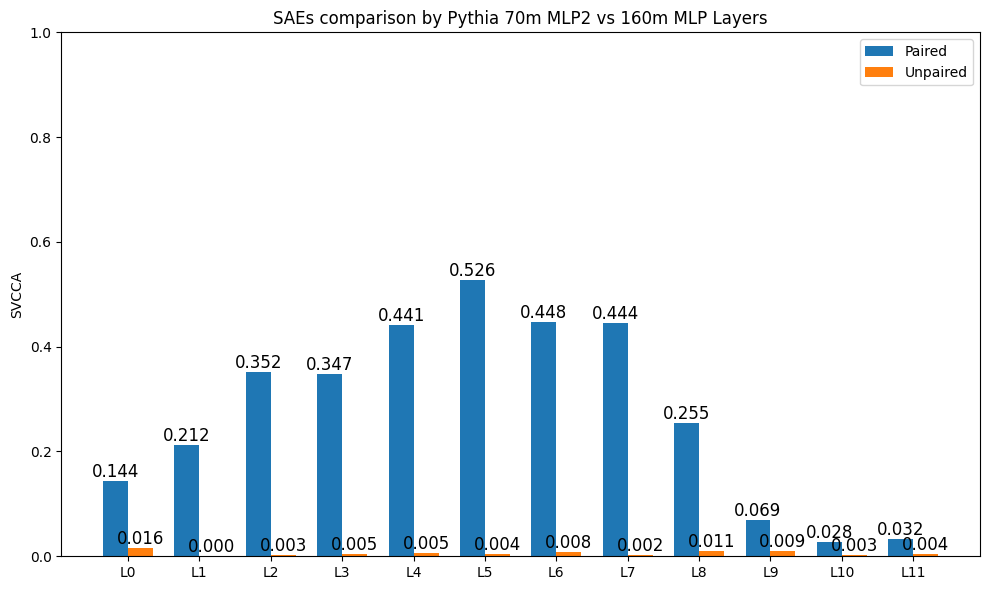

In [ ]:
plot_svcca_byLayer(layer_to_dictscores)

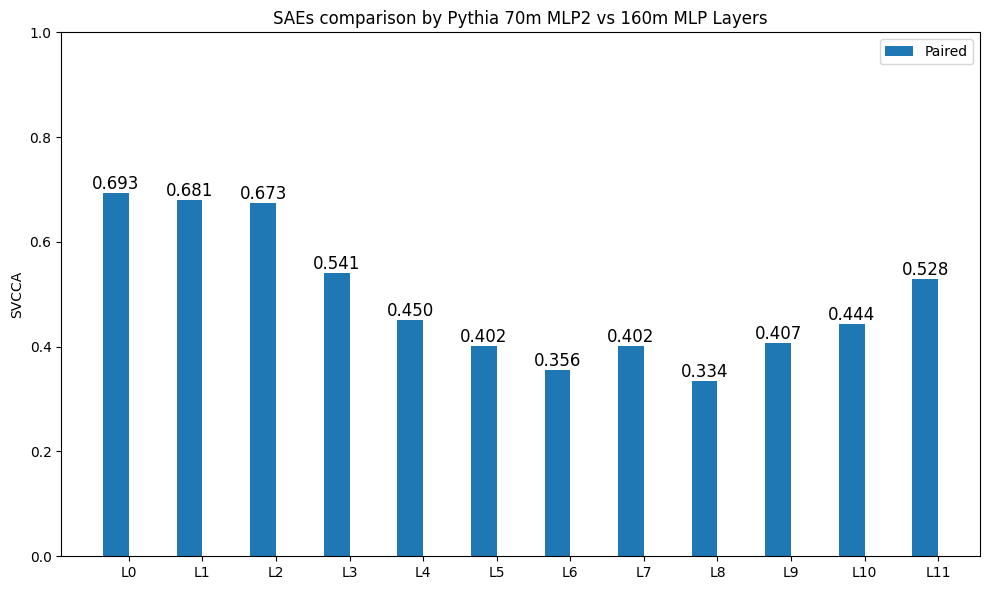

In [ ]:
plot_meanCorr_filt_byLayer(layer_to_dictscores)

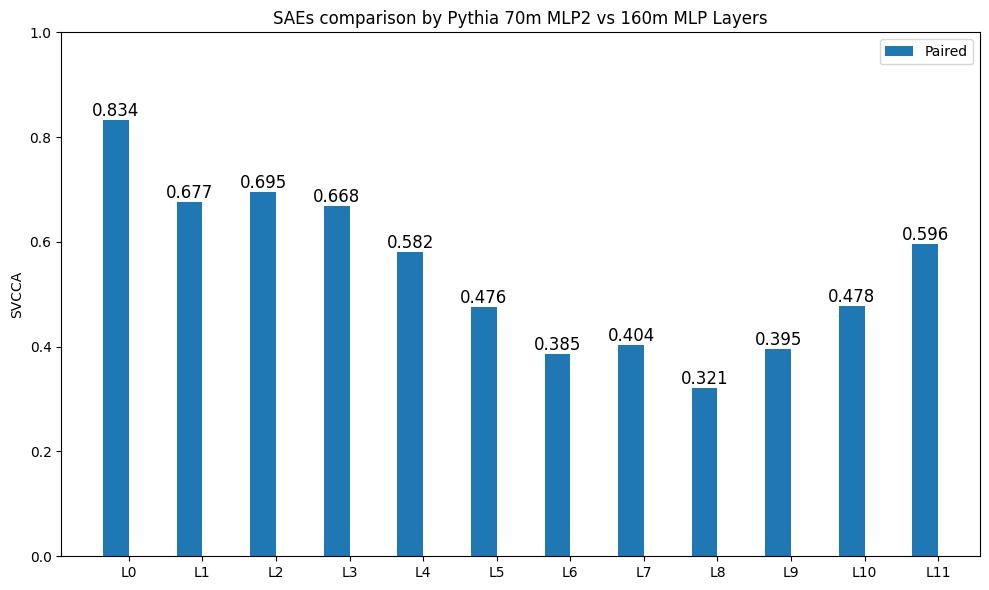

In [ ]:
plot_meanCorr_byLayer(layer_to_dictscores)